# **Regularized Linear Regression**

This notebook is showing how to do common statistical learning techniques with Python. 

We will introduce an important extension to linear regression, regularization, that makes it applicable for ill-posed problems (e.g. number of predictors >> number of samples) and helps to prevent overfitting.

### Regularized Linear Regression

Sometimes the relationship between X and Y may not be represted with just degree-one terms of the features. For solving such problems, we may need to use Polynomial regresssion.

As we know a Polynomial regression fits a n-th order polynomial to our data using least squares. Which order of the polynomial should we choose? 

Clearly, the higher the order of the polynomial, the higher the complexity of the model. 
This is true both computationally and conceptually because in both cases we now have a higher number of adaptable parameters. 
The higher the complexity of a model the more variance it can capture. 

Given that computation is cheap, should we always pick the most complex model? 
As we will show below, the answer to this question is no: we have to strike a balance between variance and (inductive) bias: our model needs to have sufficient complexity to model the relationship between the predictors and the response, but it must not fit the idiosyncrasies of our training data, idiosyncrasies which will limit its ability to generalize to new, unseen cases.


This is best illustrated using a simple curve fitting example, which is adopted from **C. Bishop's Pattern Recognition and Machine Learning (2007)**. 

Let's create a synthetic dataset by adding some random gaussian noise to a sinusoidal function.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
np.random.seed(9)

def f(x):
 return np.sin(2 * np.pi * x)

In [ ]:
# generate points used to plot
x_plot = np.linspace(0, 1, 100)

In [ ]:
# generate points and keep a subset of them
n_samples = 100
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)


In [ ]:
X.shape

(442, 10)

Text(0.5, 0, 'x')

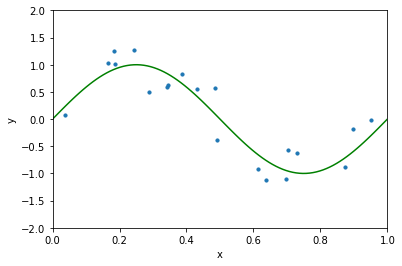

In [ ]:
ax = plt.gca()
ax.plot(x_plot, f(x_plot), color='green')
ax.scatter(X_train, y_train, s=10)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('x')

## Polynomial Regression

Now let's see how different polynomials can approximate this curve.

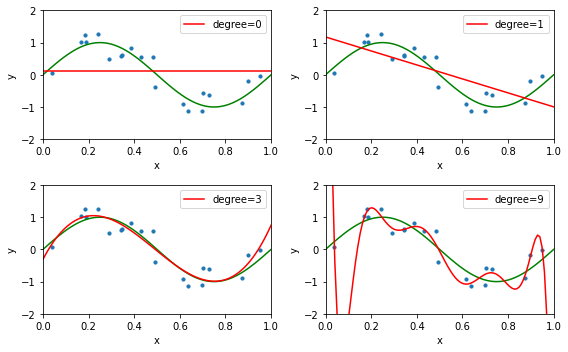

In [ ]:
def plot_approximation(est, ax, label=None):

 """Plot the approximation of ``est`` on axis ``ax``. """

 ax.plot(x_plot, f(x_plot), color='green')
 ax.scatter(X_train, y_train, s=10)
 ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
 ax.set_ylim((-2, 2))
 ax.set_xlim((0, 1))
 ax.set_ylabel('y')
 ax.set_xlabel('x')
 ax.legend(loc='upper right')  #, fontsize='small')

fig, axes = plt.subplots(2, 2, figsize=(8, 5))
# fit different polynomials and plot approximations
for ax, degree in zip(axes.ravel(), [0, 1, 3, 9]):
  est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
  est.fit(X_train, y_train)
  plot_approximation(est, ax, label='degree=%d' % degree)
plt.tight_layout()

In the plot above we see that the polynomial of degree zero is just a constant approximation, the polynomial of degree one fits a straight line, the polynomial of degree three nicely approximates the ground truth, and finally, the polynomial of degree nine has nearly zero training error but does a poor job approximating the ground truth because it already fits the variance induced by the random gaussian noise that we added to our data.

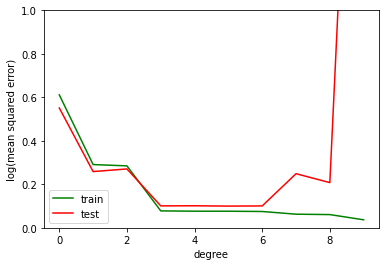

In [ ]:
from sklearn.metrics import mean_squared_error

train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
 est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
 est.fit(X_train, y_train)
 train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
 test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='lower left')


**Explanation of the Plot Above**

If we plot the training and testing error as a function of the degree of the polynomial we can see what's happening: the higher the degree of the polynomial (our proxy for model complexity), the lower the training error.
 The testing error decreases too, but it eventually reaches its minimum at a degree of three and then starts increasing at a degree of seven.

This phenomenon is called **overfitting**: the model is already so complex that it fits the idiosyncrasies of our training data, idiosyncrasies which limit the model's ability to generalize (as measured by the testing error).

In the above example, the optimal choice for the degree of the polynomial approximation would be between three and six. 

**However, there is an alternative to manually selecting the degree of the polynomial: we can add a constraint to our linear regression model that constrains the magnitude of the coefficients in the regression model. 
This constraint is called the regularization term and the technique is often called shrinkage in the statistical community because it shrinks the coefficients towards zero.** 

In the context of polynomial regression, constraining the magnitude of the regression coefficients effectively is a smoothness assumption: by constraining the **L2 norm** of the regression coefficients we express our preference for **smooth functions rather than wiggly functions**.

## Ridge Regression

A popular regularized linear regression model is Ridge Regression. This adds the L2 norm of the coefficients to the ordinary least squares objective:

**J(β)=1n∑ni=0(yi−βTx′i)2+α∥β∥2**

where **β is the vector of coefficients including the intercept term** and **x′i is the i-th feature fector including a dummy feature for the intercept**. 

The ***L2 norm term is weighted by a regularization parameter alpha***:

**if alpha=0 then you recover the Ordinary Least Squares regression model.**
**The larger the value of alpha the higher the smoothness constraint.**



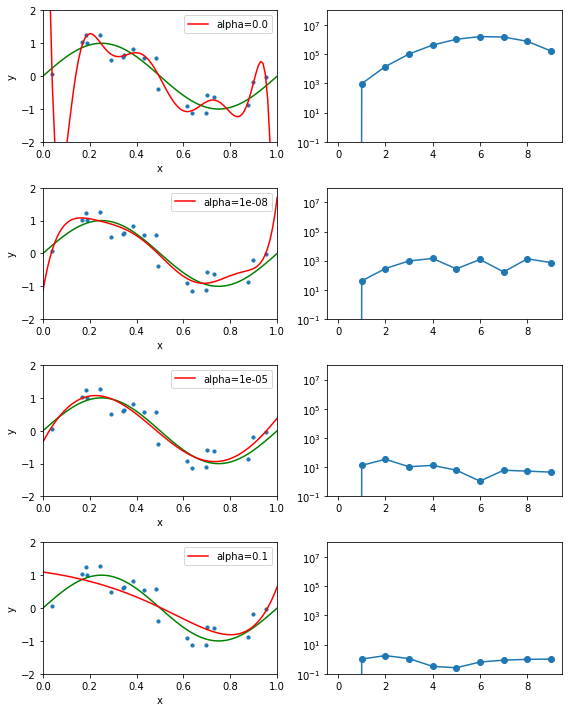

In [ ]:
fig, ax_rows = plt.subplots(4, 2, figsize=(8, 10))

def plot_coefficients(est, ax, label=None, yscale='log'):
 coef = est.steps[-1][1].coef_.ravel()
 if yscale == 'log':
  ax.semilogy(np.abs(coef), marker='o', label=label)
  ax.set_ylim((1e-1, 1e8))
 else:
  ax.plot(np.abs(coef), marker='o', label=label)
  ax.set_ylabel('abs(coefficient)')
  ax.set_xlabel('coefficients')
  ax.set_xlim((1, 9))

degree = 9
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
 ax_left, ax_right = ax_row
est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
 est.fit(X_train, y_train)
 
 plot_approximation(est, ax_left, label='alpha=%r' % alpha)
 plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)
plt.tight_layout()

Above you can see the approximation of a sklearn.linear_model.

**RidgeRegression** estimator fitting a **polynomial of degree nine** for **various values of alpha (left)** and the **corresponding coefficient loadings (right)**. 

**The smaller the value of alpha the higher the magnitude of the coefficients, so the functions we can model can be more and more wiggly.**


#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## Other Regularization Techniques - Lasso & Elastic Net

In the above example we used Ridge Regression, a regularized linear regression technique that puts an L2 norm penalty on the regression coefficients. 

Another popular regularization technique is the LASSO, a technique which puts an L1 norm penalty instead. The difference between the two is that the LASSO leads to sparse solutions, driving most coefficients to zero, whereas Ridge Regression leads to dense solutions, in which most coefficients are non-zero. 

The intuition behind the sparseness property of the L1 norm penalty can be seen in the plot below. The plot shows the value of the penalty in the coefficient space, here a space with two coefficients w0 and w1. 

**The L2 penalty appears as a cone in this space whereas the L1 penalty is a diamond.** 

The objective function of a regularized linear model is just the ordinary least squared solution plus the (weighted) penalty term (the point that minimizes the objective function is where those two error surfaces meet), so in the case of the L1 penalty this is usually at the spike of the diamond, a sparse solution because some coefficients are zero. 

For the **L2 penalty, on the other hand, the optimal point generally has non-zero coefficients**. The values of these coeffficients could be very small (close to zero) but not exactly zero. 

Another popular regularization technique is the **Elastic Net, the convex combination of the L2 norm and the L1 norm. It too leads to a sparse solution.**


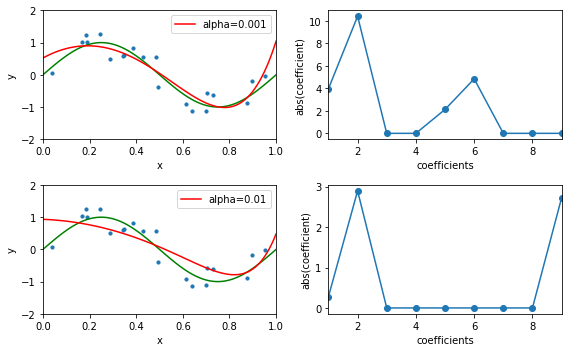

In [ ]:
from sklearn.linear_model import Lasso

fig, ax_rows = plt.subplots(2, 2, figsize=(8, 5))

degree = 9
alphas = [1e-3, 1e-2]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()

## L1 vs. L2 Regularization

**L2 and L1 regularization differ in how they cope with correlated predictors: L2 will divide the coefficient loading equally among them whereas L1 will place all the loading on one of them while shrinking the others towards zero.** 

**Elastic Net combines the advantages of both**: it tends to either select a group of correlated predictors in which case it puts equal loading on all of them, or it completely shrinks the group.

Scikit-learn provides separate classes for LASSO and Elastic Net: **sklearn.linear_model.Lasso** and **sklearn.linear_model.ElasticNet**. 

In contrast to RidgeRegression, the solution for both LASSO and Elastic Net has to be computed numerically. The classes above use an optimization technique called coordinate descent. 
Alterntively, you can also use the class sklearn.linear_model.SGDRegressor which uses stochastic gradient descent instead and often is more efficient for large-scale, high-dimensional and sparse data.

Lasso and elastic net (L1 and L2 penalisation) implemented using a coordinate descent.

The coefficients can be forced to be positive.

## Regularization Path Plots

Another handy diagnostic tool for regularized linear regression is the use of so-called regularization path plots. 

**These show the coefficient loading (y-axis) against the regularization parameter alpha (x-axis).** 

**Each (non-zero) coefficient is represented by a line in this space. **

The example below is taken from the scikit-learn documentation. 

**You can see that the smaller the alpha (i.e. the higher the –log(alpha), the higher the magnitude of the coefficients and the more predictors selected).** 

**You can also see that the Elastic Net tends to select more predictors, distributing the loading evenly among them, whereas L1 tends to select fewer predictors.**

Regularization path plots can be efficiently created using coordinate descent optimization methods but they are harder to create with (stochastic) gradient descent optimzation methods. 

Scikit-learn provides a number of convenience functions to create those plots for coordinate descent based regularized linear regression models: **sklearn.linear_model.lasso_path** and **sklearn.linear_model.enet_path**.


Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


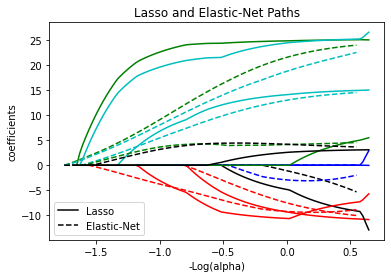

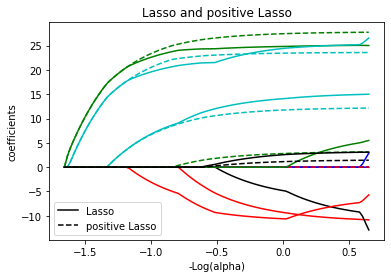

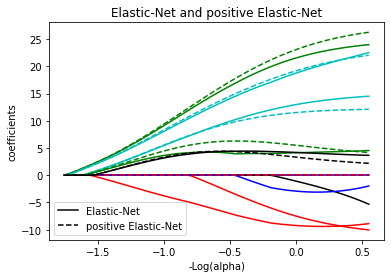

In [ ]:
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets


X, y = datasets.load_diabetes(return_X_y=True)


X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)

# Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps, fit_intercept=False)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(X, y, eps=eps, positive=True, fit_intercept=False)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(X, y, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

# Display results

plt.figure(1)
colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')


plt.figure(2)
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')


plt.figure(3)
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()